# Leaf Classify
### Imports

In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torchinfo import summary
from torchinfo import summary
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassAUROC

from sklearn.metrics import classification_report
from sklearn.neighbors import Line

import matplotlib.pyplot as plt

from tqdm import tqdm

import math
from os import walk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Auxiliary functions

In [7]:
def show_leaf(image,label):
    plt.imshow(image.permute(1,2,0))
    plt.title(f'class = {label}')
    plt.xticks([])
    plt.yticks([])

### Load the dataset

In [8]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.ImageFolder('./leaf_disease_dataset', transform=transform)

### Split into train test and val sets

In [9]:
generator = torch.Generator().manual_seed(42)

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=generator)

print("Length of the train set: " + str(len(train_dataset)))
print("Length of the test set: " + str(len(test_dataset)))
print("Length of the val set: " + str(len(val_dataset)))

Length of the train set: 15466
Length of the test set: 3314
Length of the val set: 3313


In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

### Show an example image

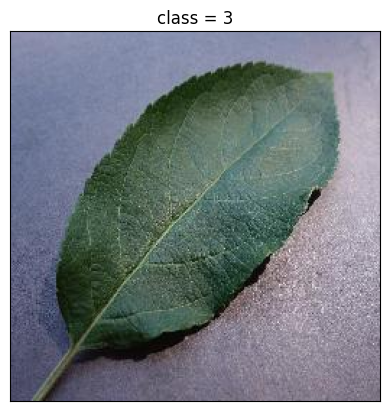

In [11]:
images, labels = next(iter(train_loader))

show_leaf(images[0],labels[0])

### Define a tradicional ML method

In [18]:
class LinearClassifier(nn.Module):
    def __init__(self,input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        z = self.linear(x)
        return z

In [19]:
input_dim = 3*256*256
output_dim = 38
lc = LinearClassifier(input_dim,output_dim)
summary(lc)

Layer (type:depth-idx)                   Param #
LinearClassifier                         --
├─Linear: 1-1                            7,471,142
Total params: 7,471,142
Trainable params: 7,471,142
Non-trainable params: 0

### Define the CV model

In [20]:
class CNNClassifier(nn.Module):
    def __init__(
        self, 
        n_channels=[32,64,128], 
        kernel_sizes=[5,3,3], 
        hidden=64, 
        stride=1, 
        padding=0,
        input_size = [3,256],
        n_classes = 38
    ):
        super(CNNClassifier, self).__init__()

        #IN: 256*256*3 = 196608
        #OUT: (256-kernel_sizes[0]+2*padding)/stride + 1
        #EX: (256-6+2*0)/1 + 1 = 251
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=n_channels[0],
            kernel_size=kernel_sizes[0],
            stride=stride,
            padding=padding
        )

        out_size_conv1 = math.floor(
            (input_size[1] - kernel_sizes[0] + 2*padding)/stride + 1
        )
        #POOLING: floor(251/2) = 125
        out_size_pool1 = math.floor(out_size_conv1/2)

        #IN: 125*125*n_channels[0]
        #EX: 125*125*64 = 1000000
        #OUT: (125-kernel_sizes[1]+2*padding)/stride + 1
        #EX: (125-6+2*0)/1 + 1 = 120
        self.conv2 = nn.Conv2d(
            in_channels=n_channels[0],
            out_channels=n_channels[1],
            kernel_size=kernel_sizes[1],
            stride=stride,
            padding=padding
        )

        out_size_conv2 = math.floor(
            (out_size_pool1 - kernel_sizes[1] + 2*padding)/stride + 1
        )
        #POOLING: floor(120/2) = 60
        out_size_pool2 = math.floor(out_size_conv2/2)

        #IN: 60*60*n_channels[1]
        #EX: 60*60*128 = 460800
        #OUT: (60-kernel_sizes[2]+2*padding)/stride + 1
        #EX: (60-6+2*0)/1 + 1 = 55
        self.conv3 = nn.Conv2d(
            in_channels=n_channels[1],
            out_channels=n_channels[2],
            kernel_size=kernel_sizes[2],
            stride=stride,
            padding=padding
        )

        out_size_conv3 = math.floor(
            (out_size_pool2 - kernel_sizes[2] + 2*padding)/stride + 1
        )

        out_size_pool3 = math.floor(out_size_conv3/2)

        self.pool = nn.MaxPool2d(
            kernel_size=2
        )

        #IN: 55*55*n_channels[2]
        #EX: 774400
        self.lin1 = nn.Linear(out_size_pool3*out_size_pool3*n_channels[2],hidden)
        self.lin2 = nn.Linear(hidden,n_classes)

        self.relu = nn.ReLU()
        

    def forward(self,x):
        z = self.conv1(x)
        z = self.relu(z)
        z = self.pool(z)

        z = self.conv2(z)
        z = self.relu(z)
        z = self.pool(z)

        z = self.conv3(z)
        z = self.relu(z)
        z = self.pool(z)

        z = z.view(z.size(0),-1)
        z = self.relu(self.lin1(z))
        z = self.lin2(z)
        return z

In [21]:
torch.cuda.empty_cache()
cnn = CNNClassifier()
batch_size = 32
summary(cnn,input_size=(batch_size,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [32, 38]                  --
├─Conv2d: 1-1                            [32, 32, 252, 252]        2,432
├─ReLU: 1-2                              [32, 32, 252, 252]        --
├─MaxPool2d: 1-3                         [32, 32, 126, 126]        --
├─Conv2d: 1-4                            [32, 64, 124, 124]        18,496
├─ReLU: 1-5                              [32, 64, 124, 124]        --
├─MaxPool2d: 1-6                         [32, 64, 62, 62]          --
├─Conv2d: 1-7                            [32, 128, 60, 60]         73,856
├─ReLU: 1-8                              [32, 128, 60, 60]         --
├─MaxPool2d: 1-9                         [32, 128, 30, 30]         --
├─Linear: 1-10                           [32, 64]                  7,372,864
├─ReLU: 1-11                             [32, 64]                  --
├─Linear: 1-12                           [32, 38]                  

### Define training process

In [22]:
def train_model(
    cnn, 
    n_epochs,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion
):
    accuracies = []
    
    for epoch in tqdm(range(n_epochs)):
        #training
        for x_train,y_train in train_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)
            
            optimizer.zero_grad()
            z = cnn(x_train)
            loss = criterion(z,y_train)
            loss.backward()
            optimizer.step()

        correct = 0
        #evaluation
        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                z_test = cnn(x_test)
                _,y_pred = torch.max(z_test.data,1)
                correct += (y_pred == y_test).sum().item()

        accuracies.append(correct/len(test_loader.dataset))

    return accuracies

In [23]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

accuracies = train_model(cnn,10,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch 0:
Epoch 1:
Epoch 2:
Epoch 3:
Epoch 4:
Epoch 5:
Epoch 6:
Epoch 7:
Epoch 8:
Epoch 9:


In [24]:
print(accuracies)

[0.6952323476161738, 0.7380808690404346, 0.7896801448400724, 0.7631261315630657, 0.7896801448400724, 0.7664453832226916, 0.7730838865419433, 0.812009656004828, 0.7851538925769463, 0.7797223898611949]


In [25]:
#Save the model
torch.save(cnn.state_dict(), "./cnn.pt")

### Define transfer learning model